## install software and data

In [33]:
!pip -q install neurom --upgrade
!pip uninstall -y nsg-bluepyopt-job
!pip -q install https://github.com/jdcourcol/InSilicoNeuroscienceCourse/raw/master/nsg-portal-course/utils/nsg-bluepyopt-job-0.0.1.dev0.tar.gz
!mkdir -p ./tmp/
!curl https://github.com/jdcourcol/InSilicoNeuroscienceCourse/raw/master/nsg-portal-course/model/initial_data.tar.gz| tar x -C ./tmp
WORKING_DIR = './tmp/hippo-ca1'
    

Uninstalling nsg-bluepyopt-job-0.0.1.dev0:
  Successfully uninstalled nsg-bluepyopt-job-0.0.1.dev0
You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://github.com/jdcourcol/InSilicoNeuroscienceCourse/raw/master/nsg-portal-course/utils/nsg-bluepyopt-job-0.0.1.dev0.tar.gz
  Running setup.py bdist_wheel for nsg-bluepyopt-job ... done
  Stored in directory: /home/courcol/.cache/pip/wheels/42/d0/f8/729f5f9139b64f4480ab4c16b56ef3d72c2bb8e562fc8ae410
Successfully built nsg-bluepyopt-job
You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
%load_ext autoreload
%autoreload
import getpass
import os.path
from __future__ import print_function
import pprint
pp = pprint.PrettyPrinter(indent=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Enable the code below to enable debug level logging

In [3]:
# import logging                                                                      
# logging.basicConfig()                                                               
# logger = logging.getLogger()                                                        
# logger.setLevel(logging.DEBUG)   

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software:

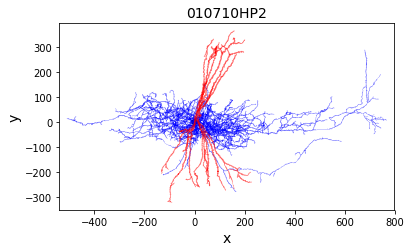

In [7]:
import neurom.viewer
neurom.viewer.draw(neurom.load_neuron(os.path.join(WORKING_DIR, 'morphology', '010710HP2.asc')));

To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a AIS.

### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [8]:
import json
param_configs = json.load(open(os.path.join(WORKING_DIR,'config.orig/parameters.json')))
print(param_configs)

{u'INT_cAC_noljp': {u'distributions': {}, u'optimized': {u'allnoaxon': [[u'ghdbar_hd', 1e-06, 0.0005, u'uniform'], [u'gcalbar_cal', 1e-06, 3e-05, u'uniform'], [u'gcanbar_can', 1e-06, 3e-05, u'uniform'], [u'gcatbar_cat', 1e-06, 3e-05, u'uniform'], [u'gbar_kca', 1e-06, 1e-05, u'uniform'], [u'gbar_cagk', 5e-06, 0.0003, u'uniform'], [u'Ra', 50, 400, u'secvar'], [u'g_pas', 1e-06, 0.0002, u'uniform'], [u'e_pas', -100, -50, u'uniform']], u'alldend': [[u'gbar_nax', 0.005, 0.05, u'uniform'], [u'gkdrbar_kdrb', 0.001, 0.8, u'uniform'], [u'gkabar_kap', 0.001, 0.1, u'uniform']], u'all': [], u'axonal': [[u'gbar_nax', 0.025, 0.15, u'uniform'], [u'gkdrbar_kdrb', 0.01, 0.08, u'uniform'], [u'gkabar_kap', 0.001, 0.04, u'uniform'], [u'gbar_kmb', 0.004, 0.05, u'uniform'], [u'Ra', 50, 300, u'secvar'], [u'g_pas', 1e-06, 8e-05, u'uniform'], [u'e_pas', -95, -75, u'uniform']], u'somatic': [[u'gbar_nax', 0.01, 0.1, u'uniform'], [u'gkdrbar_kdrb', 0.001, 0.08, u'uniform'], [u'gkabar_kap', 0.005, 0.04, u'uniform'],

The directory that contains this notebook has a module that will load all the parameters in BluePyOpt Parameter objects

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [9]:
proto_configs = json.load(open(os.path.join(WORKING_DIR, 'config.orig/protocols.json')))
print(proto_configs)

{u'INT_cAC_noljp': {u'step_-0.4': {u'stimuli': [{u'delay': 531.0, u'amp': -0.4, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.8': {u'stimuli': [{u'delay': 531.0, u'amp': 0.8, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.2': {u'stimuli': [{u'delay': 531.0, u'amp': 0.2, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.4': {u'stimuli': [{u'delay': 531.0, u'amp': 0.4, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_0.6': {u'stimuli': [{u'delay': 531.0, u'amp': 0.6, u'duration': 400.0, u'totduration': 1131.0}, {u'delay': 0.0, u'amp': 0.0, u'duration': 1131.0, u'totduration': 1131.0}]}, u'step_-0.2': {u'stimuli': [{u'delay': 531.0, u'amp': -0.2, u'duration': 400.0

## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

In [10]:
feature_configs = json.load(open(os.path.join(WORKING_DIR,'config.orig/features.json')))
pp.pprint(feature_configs)

{ u'INT_cAC_noljp': { u'step_-0.2': { u'soma': { u'voltage_base': [ -74.95850220567962,
                                                                    2.868751014477237],
                                                 u'voltage_deflection': [ -9.859241453008528,
                                                                          1.0756047499453203]}},
                      u'step_-0.4': { u'soma': { u'voltage_base': [ -74.61759546457128,
                                                                    2.1406043489404434],
                                                 u'voltage_deflection': [ -19.772462606879138,
                                                                          2.033148883516023]}},
                      u'step_0.2': { u'soma': { u'Spikecount': [ 0.8333333333333334,
                                                                 1.178511301977579],
                                                u'inv_first_ISI': [ 4.303645236358828,
        

modify configuration here...

## save configuration

In [12]:
for variable, filename in zip([param_configs, proto_configs, feature_configs],['parameters.json', 'protocols.json', 'features.json']):
    with open(os.path.join(WORKING_DIR, 'config', filename), 'w') as f:
        json.dump(variable, f)
!tar -cf './bluepyopt-config.tar.gz' './tmp/hippo-ca1'

## launch optimization on the nsg-portal compute center

In [19]:
user = #'put your nsg_portal account id here'

In [20]:
password = getpass.getpass('provide your password:')

provide your password········


In [21]:
import nsg_bluepyopt_job.job as job

In [22]:
job_url = job.launch_opt(user, password, './bluepyopt-config.tar.gz')

In [23]:
output_url = job.wait_completion(job_url, user, password, 30)

INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/courcol/NGBW-JOB-BLUEPYOPT_TG-4E195A47F81345BC9F099E7FAD3F2371, courcol, xxxx)
INFO:nsg_bluepyopt_job.job:waiting 30 s
INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/courcol/NGBW-JOB-BLUEPYOPT_TG-4E195A47F81345BC9F099E7FAD3F2371, courcol, xxxx)
INFO:nsg_bluepyopt_job.job:waiting 30 s
INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/courcol/NGBW-JOB-BLUEPYOPT_TG-4E195A47F81345BC9F099E7FAD3F2371, courcol, xxxx)
INFO:nsg_bluepyopt_job.job:waiting 30 s
INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/courcol/NGBW-JOB-BLUEPYOPT_TG-4E195A47F81345BC9F099E7FAD3F2371, courcol, xxxx)
INFO:nsg_bluepyopt_job.job:waiting 30 s
INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/courcol/NGBW-JOB-BLUEPYOPT_TG-4E195A47F81345BC9F099E7FAD3F2371, courcol, xxxx)


ConnectionError: HTTPSConnectionPool(host='nsgr.sdsc.edu', port=8443): Max retries exceeded with url: /cipresrest/v1/job/courcol/NGBW-JOB-BLUEPYOPT_TG-4E195A47F81345BC9F099E7FAD3F2371 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fb3a45c7110>: Failed to establish a new connection: [Errno 111] Connection refused',))

In [ ]:
checkpoint_pkl = job.download_output(output_url, './tmp/')